In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal

In [53]:
sns.set_theme()
beta_true = [.05, .2, .3, .4]
alpha = 0.1
gamma = 0.05
n_zones = 3
N = 100 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = np.array([-3.9, -2.3, -2.3, -2.3])
prior_sigma = np.ones(4)

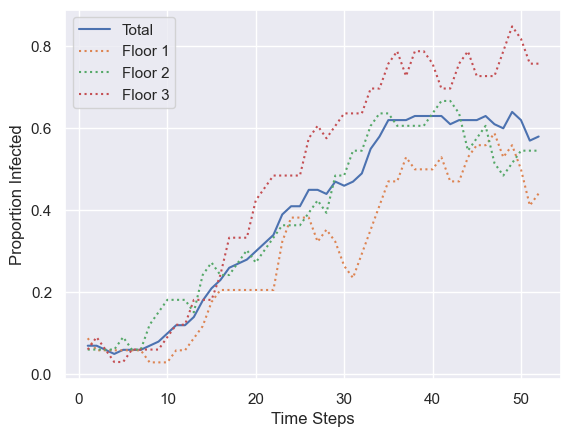

In [54]:
si_model = SIModel(alpha, gamma, beta_true, n_zones,
                   prior_mu, prior_sigma, N, T, summarize=False, observed_seed=31)
x_o = si_model.get_observed_data()
x_o = x_o.unflatten(1, (n_zones+1,T)).squeeze(0)

df_x = pd.DataFrame(
    data = np.array(x_o).T,
    index = np.arange(1,53),
    columns = ["Total", "Floor 1", "Floor 2", "Floor 3"]
)

sns.lineplot(df_x["Total"], label="Total")
sns.lineplot(df_x["Floor 1"], linestyle=":", label = "Floor 1")
sns.lineplot(df_x["Floor 2"], linestyle=":", label = "Floor 2")
sns.lineplot(df_x["Floor 3"], linestyle=":", label = "Floor 3")
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.legend()
plt.show()

## Prior

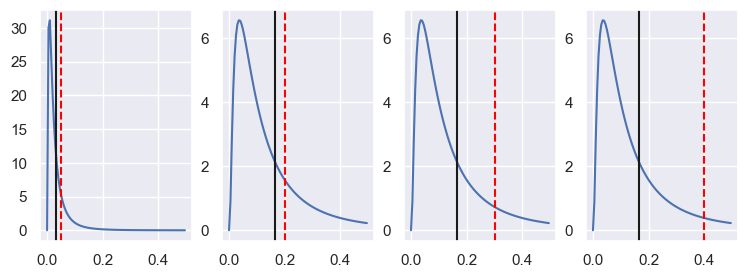

In [55]:
x = np.arange(0, 0.5, 0.005)
fig, axs = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(9)

#TODO: generalize to multidim prior
prior_mean = np.exp(prior_mu + prior_sigma**2/2)

for i in range(4):
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu[i]), s=prior_sigma[i]),
                ax=axs[i])
    axs[i].axvline(beta_true[i], color="red", linestyle="--")
    axs[i].axvline(prior_mean[i], color="k")
plt.show()

In [10]:
# x = np.arange(-6, 1, 0.05)
# fig, axs = plt.subplots(1, 4)
# fig.set_figheight(3)
# fig.set_figwidth(9)

# for i in range(4):
#     sns.lineplot(x=x, y=norm.pdf(x, loc=prior_mu[i], scale=prior_sigma[i]),
#                 ax=axs[i])
#     axs[i].axvline(np.log(beta_true[i]), color="red", linestyle="--")
#     # axs[i].axvline(prior_mean[i], color="k")
# plt.show()

### Prior Predictive Check

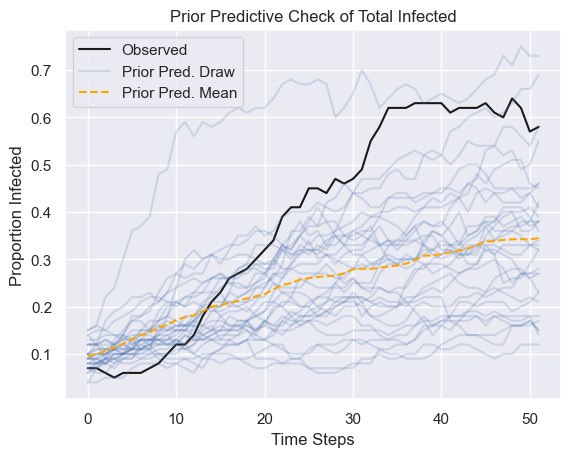

In [56]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=(K, n_zones+1), random_state=2))
prior_predictive = np.empty((K,n_zones+1,T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False, observed_seed=31)
    x_rep = si_model.get_observed_data(i)
    x_rep = x_rep.unflatten(1, (n_zones+1, T)).squeeze(0)
    prior_predictive[i] =  np.array(x_rep)
prp_mean = prior_predictive.mean(0)[0]

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Total Infected")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

### NPE

In [176]:
df_npe = pd.DataFrame({
    "Method": ["NPE"] * 5,
    "simulations": [500, 1000, 2000, 4000, 8000],
    "mean": [[-2.937, -2.666, -2.066, -1.174], [-2.95,  -2.642, -1.861, -1.164], [-3.039, -2.501, -1.986, -1.062],
            [-2.848, -2.488, -2.146, -1.118], [-2.976, -2.485, -1.857, -1.101]],
    "sd": [[0.592, 0.917, 0.673, 0.629], [0.55,  0.97,  0.664, 0.471], [0.599, 0.785, 0.634, 0.381],
          [0.537, 0.815, 0.73, 0.439], [0.609, 0.835, 0.678, 0.454]],
    "Beta": [[0,1,2,3]] * 5
})

In [177]:
df_npe = df_npe.explode(["mean", "sd", "Beta"])
df_npe["mean"] = df_npe["mean"].astype(float)
df_npe["sd"] = df_npe["sd"].astype(float)
df_npe[".05"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.05))
df_npe[".95"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.95))
df_npe["Posterior Mean"] = np.exp(df_npe["mean"] + df_npe["sd"]**2/2)

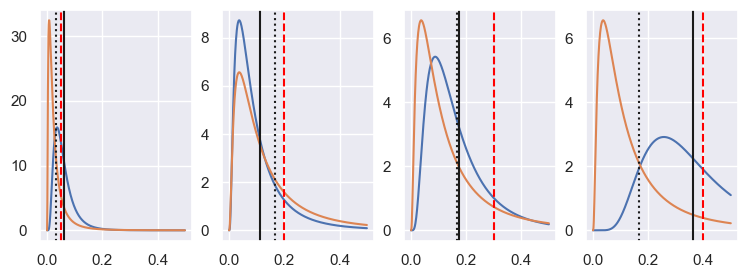

In [178]:
# npe_mu = df_npe.groupby("Beta")["mean"].mean().values
# npe_sigma = df_npe.groupby("Beta")["sd"].mean().values
posterior_mean = np.exp(np.array(npe_mu) + np.array(npe_sigma)**2/2)
x = np.arange(0., 0.5, 0.001)
fig, axs = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(9)

for i in range(4):
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(npe_mu[i]), s=npe_sigma[i]), 
                ax=axs[i])
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu[i]), s=prior_sigma[i]),
                ax=axs[i])
    axs[i].axvline(beta_true[i], color="red", linestyle="--")
    axs[i].axvline(posterior_mean[i], color="k")
    axs[i].axvline(prior_mean[i], color="k", linestyle=":")
plt.show()

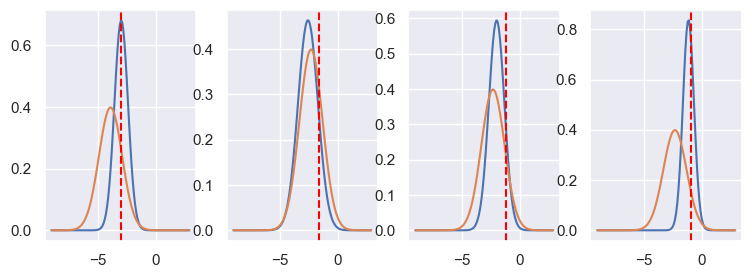

In [179]:
# npe_mu = df_npe.groupby("Beta")["mean"].mean().values
# npe_sigma = df_npe.groupby("Beta")["sd"].mean().values

posterior_mean = np.exp(np.array(npe_mu) + np.array(npe_sigma)**2/2)
x = np.arange(-9., 3, 0.1)
fig, axs = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(9)

for i in range(4):
    sns.lineplot(x=x, y=norm.pdf(x, loc = npe_mu[i], scale=npe_sigma[i]), 
                ax=axs[i])
    sns.lineplot(x=x, y=norm.pdf(x, loc=prior_mu[i], scale=prior_sigma[i]),
                ax=axs[i])
    axs[i].axvline(np.log(beta_true[i]), color="red", linestyle="--")
    # axs[i].axvline(posterior_mean[i], color="k")
    # axs[i].axvline(prior_mean[i], color="k", linestyle=":")
plt.show()

In [90]:
# posterior_mean = np.exp(np.array(npe_mu) + np.array(npe_sigma)**2/2)
# x = np.arange(-6., 0, 0.01)
# fig, axs = plt.subplots(1, 3)
# fig.set_figheight(3)
# fig.set_figwidth(9)

# for i in range(3):
#     sns.lineplot(x=x, y=norm.pdf(x, npe_mu[i], npe_sigma[i]), 
#                 ax=axs[i])
#     sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma),
#                 ax=axs[i])
#     axs[i].axvline(np.log(beta_true[i]), color="red", linestyle="--")
# plt.show()

## Posterior Predictive Checks

In [169]:
neural_posterior = multivariate_normal(npe_mu, np.diag(npe_sigma))
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K,n_zones+1, T))

si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=False, observed_seed=31)
x_o = si_model.get_observed_data()
x_o = x_o.unflatten(1, (n_zones+1,T)).squeeze(0)

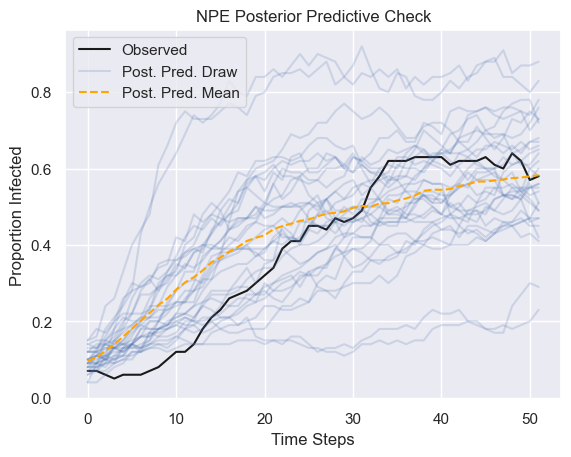

In [170]:
for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False, observed_seed=31)
    x_rep = si_model.get_observed_data(i)
    x_rep = x_rep.unflatten(1, (n_zones+1, T)).squeeze(0)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[0]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("NPE Posterior Predictive Check")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## ABC

In [30]:
# testing
eps = 3.3
summarize = False
si_model = SIModel(alpha, gamma, beta_true, 
                n_zones, prior_mu, prior_sigma, 
               N, T, summarize=summarize, observed_seed=31)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data()
x_o = x_o.reshape(-1, si_model.d_theta)
S = 100

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, simulator, x_o, max_attempts=100000,
    summarize=summarize
    )
np.exp(posterior_sample).mean(0)

Attempts: 5,000
Attempts: 10,000
Attempts: 15,000
Attempts: 20,000
Time lapsed: 55.14 seconds
With tolerance 3.3, acceptance rate: 0.004972
Total number of attempts: 20,112


array([0.06301234, 0.11425235, 0.12449092, 0.11864782], dtype=float32)

In [23]:
eps = .15
summarize = True
si_model = SIModel(alpha, gamma, beta_true, 
                n_zones, prior_mu, prior_sigma, 
               N, T, summarize=summarize, observed_seed=31)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data()
x_o = x_o.reshape(-1, si_model.d_theta)
S = 100

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, simulator, x_o, max_attempts=200000,
    summarize=summarize
    )
np.exp(posterior_sample).mean(0)

Time lapsed: 6.30 seconds
With tolerance 0.15, acceptance rate: 0.041736
Total number of attempts: 2,396


array([0.06000309, 0.0913916 , 0.1536487 , 0.26235   ], dtype=float32)

In [37]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = [(False, [3.8, 3.6, 3.5, 3.4, 3.3]),
        (True, [0.3, 0.2, .15, 0.1, 0.08])]
for summarize, es in args:
    for epsilon in es:
        si_model = SIModel(alpha, gamma, beta_true, 
                        n_zones, prior_mu, prior_sigma, 
                       N, T, summarize, observed_seed=31)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data()
        x_o = x_o.reshape(-1, si_model.d_theta)
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=40000,
            summarize=summarize
            )
        print("***")
        abc_data["summarize"].append(summarize)
        abc_data["epsilon"].append(epsilon)
        abc_data["simulations"].append((errors > 0).sum())
        abc_samples.append(posterior_sample)   

epsilon: 3.8
Time lapsed: 1.66 seconds
With tolerance 3.8, acceptance rate: 0.166389
Total number of attempts: 601
***
epsilon: 3.6
Time lapsed: 3.44 seconds
With tolerance 3.6, acceptance rate: 0.078247
Total number of attempts: 1,278
***
epsilon: 3.5
Time lapsed: 5.89 seconds
With tolerance 3.5, acceptance rate: 0.045351
Total number of attempts: 2,205
***
epsilon: 3.4
Attempts: 5,000
Time lapsed: 15.40 seconds
With tolerance 3.4, acceptance rate: 0.016059
Total number of attempts: 6,227
***
epsilon: 3.3
Attempts: 5,000
Attempts: 10,000
Attempts: 15,000
Time lapsed: 42.96 seconds
With tolerance 3.3, acceptance rate: 0.006391
Total number of attempts: 15,647
***
epsilon: 0.3
Time lapsed: 1.00 seconds
With tolerance 0.3, acceptance rate: 0.265252
Total number of attempts: 377
***
epsilon: 0.2
Time lapsed: 2.70 seconds
With tolerance 0.2, acceptance rate: 0.098912
Total number of attempts: 1,011
***
epsilon: 0.15
Time lapsed: 7.43 seconds
With tolerance 0.15, acceptance rate: 0.038139
T

In [171]:
df_abc = pd.DataFrame(abc_data)
abc_posterior = np.array(abc_samples)
# df_abc = df_abc.join(pd.DataFrame(data = np.exp(abc_posterior).mean(1)))
df_abc = df_abc.join(pd.DataFrame(data = abc_posterior.mean(1)))
df_abc = df_abc.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="mean")
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")

In [172]:
df_abc2 = pd.DataFrame(abc_data).join(pd.DataFrame(data = abc_posterior.std(1)))
df_abc2 = df_abc2.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="sd")
df_abc["sd"] = df_abc2["sd"]

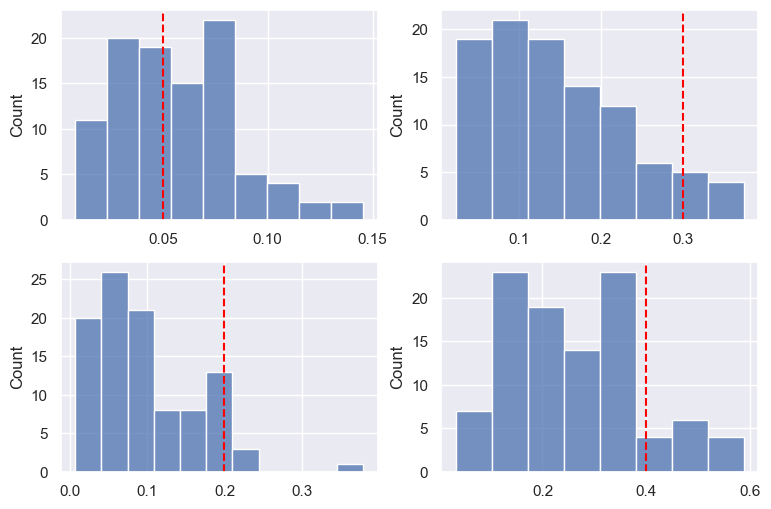

In [173]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(9)

sns.histplot(np.exp(abc_posterior)[-1,:,0],ax=axs[0, 0])
axs[0,0].axvline(beta_true[0], color="red", linestyle="--")

sns.histplot(np.exp(abc_posterior)[-1,:,1],ax=axs[1, 0])
axs[1,0].axvline(beta_true[1], color="red", linestyle="--")

sns.histplot(np.exp(abc_posterior)[-1,:,2],ax=axs[0, 1])
axs[0,1].axvline(beta_true[2], color="red", linestyle="--")

sns.histplot(np.exp(abc_posterior)[-1,:,3],ax=axs[1,1])
axs[1,1].axvline(beta_true[3], color="red", linestyle="--")

plt.show()

### Visualization

In [180]:
# cols = ["Method", "simulations", "Posterior Mean", "Beta"]
cols = ["Method", "simulations", "mean", "sd", "Beta"]
df_viz = pd.concat([df_npe[cols], df_abc[cols]])

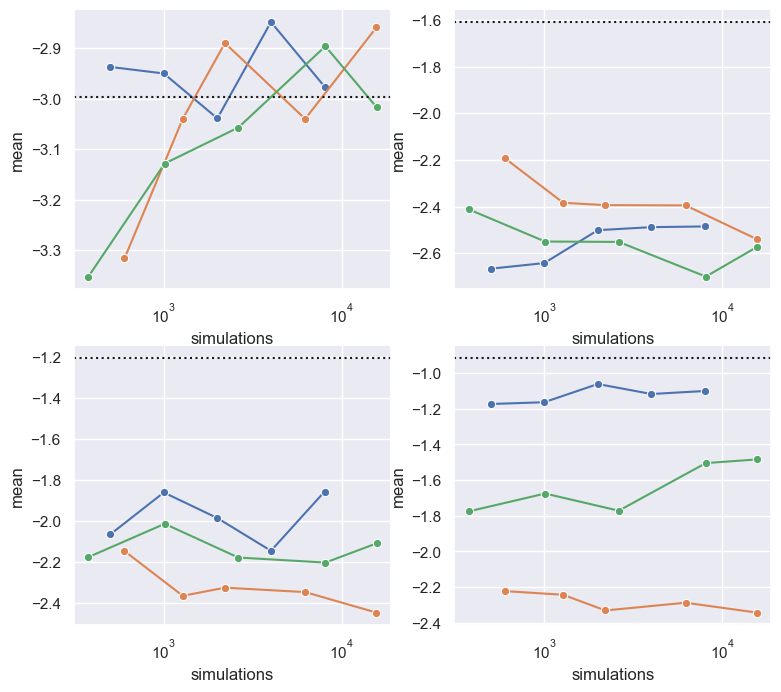

In [191]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(9)

for j, ax in enumerate(axs.flat):
    sns.lineplot(data = df_viz[df_viz["Beta"] == j] , x = "simulations", y = "mean", hue="Method", marker="o",
                ax=ax)
    ax.axhline(y = np.log(beta_true[j]), color="k", label=rf"True $\log(\beta_{j})$", linestyle=":")
    ax.get_legend().remove()
    ax.set_xscale("log")
plt.show()

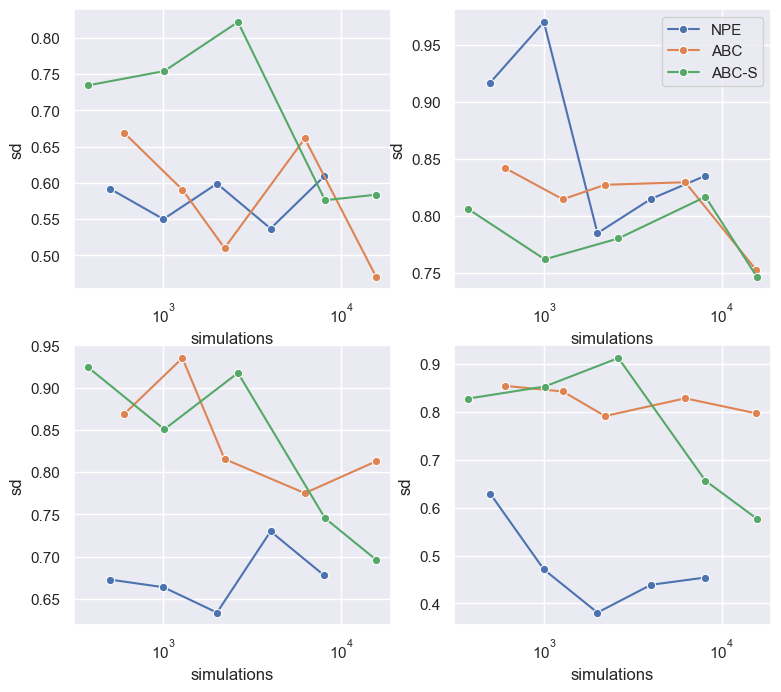

In [190]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(9)

for j, ax in enumerate(axs.flat):
    sns.lineplot(data = df_viz[df_viz["Beta"] == j] , x = "simulations", y = "sd", hue="Method", marker="o",
                ax=ax)
    # ax.axhline(y = np.log(beta_true[j]), color="k", label=rf"True $\log(\beta_{j})$", linestyle=":")
    ax.get_legend().remove()
    ax.set_xscale("log")
    if j == 1:
        ax.legend()
plt.show()

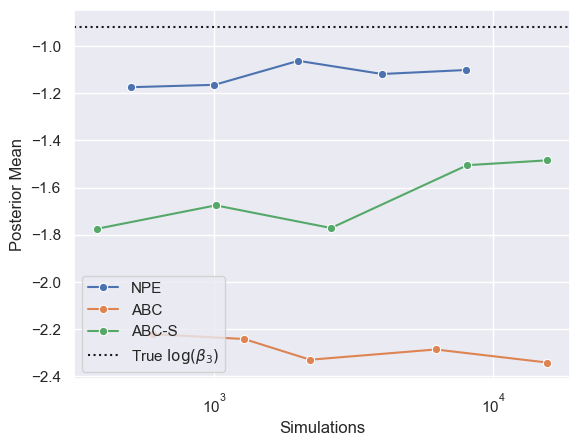

In [142]:
j = 3
fig, ax = plt.subplots()
ax = sns.lineplot(data = df_viz[df_viz["Beta"] == j] , x = "simulations", y = "mean", hue="Method", marker="o")
ax.axhline(y = np.log(beta_true[j]), color="k", label=rf"True $\log(\beta_{j})$", linestyle=":")
ax.set_xscale("log")
ax.set_xlabel("Simulations")
ax.set_ylabel("Posterior Mean")
plt.title("Simulation-based Inference of Floor")
plt.legend(loc=3)
plt.show()

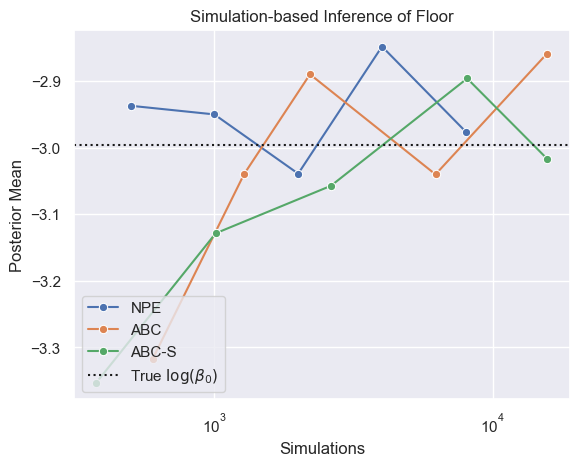

In [163]:
j = 0
fig, ax = plt.subplots()
ax = sns.lineplot(data = df_viz[df_viz["Beta"] == j] , x = "simulations", y = "mean", hue="Method", marker="o")
ax.axhline(y = np.log(beta_true[j]), color="k", label=rf"True $\log(\beta_{j})$", linestyle=":")
ax.set_xscale("log")
ax.set_xlabel("Simulations")
ax.set_ylabel("Posterior Mean")
plt.title("Simulation-based Inference of Floor")
plt.legend(loc=3)
plt.show()

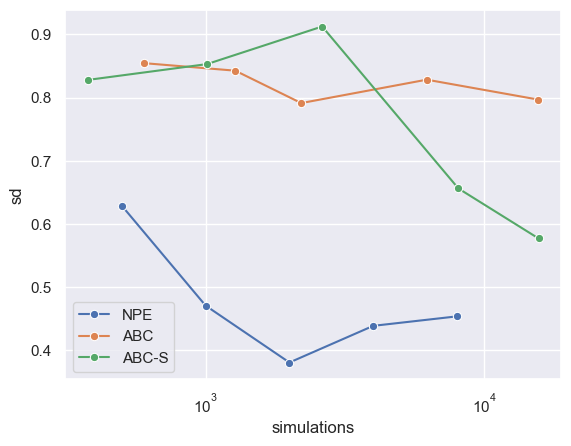

In [128]:
j = 3
sns.lineplot(data = df_viz[df_viz["Beta"] == j] , x = "simulations", y = "sd", hue="Method", marker="o")
# plt.axhline(y = np.log(beta_true[j]), color="k", label=rf"True $\log(\beta_{j})$", linestyle=":")
plt.xscale("log")
plt.legend()
plt.show()

In [79]:
df_npe.groupby("Beta")["Posterior Mean"].mean()

Beta
0    0.061939
1    0.113069
2    0.173941
3    0.365209
Name: Posterior Mean, dtype: float64

In [100]:
mu = df_npe.groupby("Beta")["mean"].mean()
sigma = df_npe.groupby("Beta")["sd"].mean()
np.exp(mu + sigma**2/2)

Beta
0    0.061834
1    0.112725
2    0.172934
3    0.363825
dtype: float64

#### Summary Statistic

In [62]:
si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=True)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)

In [65]:
S = 100
epsilon = 0.001
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=50000,
    summarize=True
)

Time lapsed: 13.06 seconds
With tolerance 0.001, acceptance rate: 0.020268
Total number of attempts: 4,934


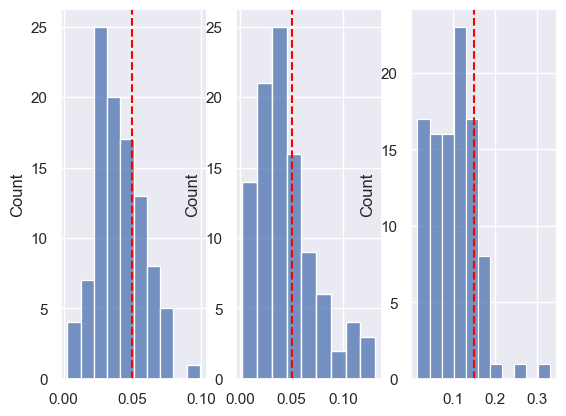

In [82]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

sns.histplot(np.exp(posterior_sample[:,0]),ax=axs[0])
axs[0].axvline(beta_true[0], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,1]),ax=axs[1])
axs[1].axvline(beta_true[1], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,2]),ax=axs[2])
axs[2].axvline(beta_true[2], color="red", linestyle="--")

plt.show()

### bagged NPE vs ABC

In [157]:
df_npe.groupby("Beta")["mean"].mean()

Beta
0   -2.9500
1   -2.5564
2   -1.9832
3   -1.1238
Name: mean, dtype: float64

In [159]:
df_npe.groupby("Beta")["sd"].mean()

Beta
0    0.5774
1    0.8644
2    0.6758
3    0.4748
Name: sd, dtype: float64

In [154]:
abc_best = df_abc[(df_abc["summarize"] == True) & (df_abc["simulations"] == df_abc["simulations"].max())]

In [155]:
abc_best["mean"]

9    -3.016956
19   -2.572680
29   -2.109664
39   -1.484584
Name: mean, dtype: float32

In [161]:
abc_best["sd"]

9     0.583802
19    0.746940
29    0.696300
39    0.577226
Name: sd, dtype: float32